### More on random forest and feature importance


In the previous's post we took data from a publication and used it to classify severe and non-severe covid19 using random forest.
Here we will look  bit more into data preprocessing, feature importance and how to visualize the results from parameter tune-up.

### Some consideration for our model

Before we trained the model naively without looking at the feature too much. We noticed that the number of features is different so we corrected for this. 
We could have either added the missing features in the test dataset as 0s or remove them from the initial dataset (which is what we did). 
**Also it is crucial to have the same order i.e same protein in test and training needs to be in the same position in the final matrix used for machine learning**.
As we noticed we reached 0.955 ROC auc with tuning, but were we learning on the same features?

Let's have a look

In [1]:
import pandas as pd
import numpy as np
import joblib

# same as before to remove proteins not present in test
train = pd.read_excel('mmc3.xlsx', sheet_name='Prot_and_meta_matrix')
test = pd.read_excel('mmc4.xlsx', sheet_name='Prot_and_meta_matrix')
train = train[train['Proteins/Metabolites'].isin(test['Proteins/Metabolites'])]
test = test[test['Proteins/Metabolites'].isin(train['Proteins/Metabolites'])]

# test for element wise
np.all(train['Proteins/Metabolites'].values == test['Proteins/Metabolites'].values)

False

**It returns False meaning that we are using different features in training and testing!**
Then logically, our accuracy could only improve by using the correctly positioned features.. 
Let's train the model again but making sure that the features are in the same position.

In [2]:
def fix_headers(df):
    """
    retrieve first row then create new headers
    """
    # trick to get column names
    oldcol = list(df)
    newcol = list(df.iloc[0])
    newcol[:2] = oldcol[:2]
    df.columns = newcol
    df.drop(df.index[0], inplace=True)
    return df


# same utility function as before
def target_features_split(info, df, sheet_name):
    """
    utility function to preprocess data and retrieve target (labels) and features (numerical values)
    """
    df.fillna(0, inplace=True)
    ids = df[['Proteins/Metabolites', 'Gene Symbol']]
    df2 = df.drop(['Proteins/Metabolites', 'Gene Symbol'], axis=1)
    # df needs to have features as columns and samples as row (i.e wide format)
    df2 = df2.T
    df2['class'] = df2.index.map(info)
    return df2.drop('class', axis=1).values, df2['class'].values



train = fix_headers(train).sort_values(['Proteins/Metabolites'])
test = fix_headers(test).sort_values(['Proteins/Metabolites'])
np.all(train['Proteins/Metabolites'].values == test['Proteins/Metabolites'].values)


True

In [3]:
# map info to data similar to previous example
info = pd.read_excel('mmc1.xlsx', index_col=0, sheet_name='Clinical_information')
info = info[info['Group d'].isin([2,3])]
info['class'] = [0 if x==2 else 1 for x in list(info['Group d'])]
info = dict(zip(info.index, info['class']))

# get training and test data in format for ml
Xtrain,ytrain = target_features_split(info, train, sheet_name='Prot_and_meta_matrix')
Xtest, ytest = target_features_split(info, test, sheet_name='Prot_and_meta_matrix')

# reload the classifier we trained before
rf_clf = joblib.load('RF_covid.clf')

# let's train the RF model and save it again
rf_clf.fit(Xtrain, ytrain)
joblib.dump(rf_clf, 'RF_covid_ordered.clf')

['RF_covid_ordered.clf']

In [4]:
def evaluate(model, test_features, test_labels):
    """
    Evaluate model accuracy
    """
    predictions = model.predict(test_features)
    ov = np.equal(test_labels, predictions)
    tp = ov[np.where(ov ==True)].shape[0]
    return tp/predictions.shape[0]

print(evaluate(rf_clf, Xtest, ytest))

0.9


Wow! As we can see we started with 70% accuracy with the default model, by tuning it we moved to 80% and by using the correct feature order we gained another 10%! So, **check the order of your feature before if the test and train datasets are different files!**

Okay, now that we re-fitted the classifier, we are ready to see another important concept for random forest, which we briefly looked yesterday, aka feature importance.

### Feature importance

Which protein/metabolites allow to separate severe and non-severe covid? 
Usually the to-go answer is to use volcano plots. In this plots, the abundance difference (log2 fold change) between the two conditions is used and then significant hits after t-test or anova are considered the 'most different'.

However in our example this is complicated to do due to the uneven number of samples between severe and non-severe covid, which could mask some variability.
As we seen in the previous post random forest can be used for this, by using feature importance. 

So let's start coding!


The easiest way to get feature importance is to check direcly in the classifier and it will return an array with the raw importance of every feature. 
We need only to map back the feature names, for this we will create a DataFrame with the features and importances and keep only the 20 features with highest importance

<AxesSubplot:xlabel='importance', ylabel='feature'>

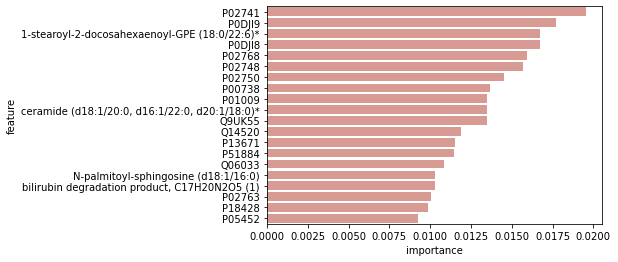

In [4]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import seaborn as sns

df = pd.DataFrame(
    {'feature': list(train['Proteins/Metabolites']),
     'importance': rf_clf.feature_importances_})

# filter features without importance
df = df[df['importance']>0]
df.sort_values(['importance'],ascending=False, inplace=True)

# keep first 20
top20 = df.iloc[0:20]
sns.barplot(x="importance", y="feature", data=top20, color="salmon", saturation=.5)


There are multiple ways to calculate feature importance, instead of using the training data we can use the test data instead for this. 
To do that we can use the test data and shuffle the feature position. 
This is quite heavy computationally, in our case we have a big number of features (>1000) so we'll skip it for now. As legacy, it can be done with the code illustrated below.

As we seen the performance depends on the feature position in the test array, so we can see which features impact performance the most by just shuffling the columns.

### More about trees and random forest

We will also visualize which parameter influenced performance and in general how to visualize the results of grid search results. We will use GridSearchCV which is going to test all combination of parameter feed as a dict.
As example we will optimize the number of trees in the forest (i.e number of estimators).

When tuning random forest this is the most important parameter, due to how random forest is constructed. This algorithm is an example of **[ensemble learning](https://towardsdatascience.com/simple-guide-for-ensemble-learning-methods-d87cc68705a2)**. We saw before that random forest is a series of weak learners (decision trees) and that every decision tree is nothing more than a series of thresholds on different features which results in separation of the data into the wanted classes (severe and non-severe covid, in our example).

From an algorithmic point of view, random forest is constructed with the following algorithm

1. Draw random subset of samples from the training data (with replacement)
2. Grow a decision tree from the samples
    2.1 Randomly select features without replacement
    2.2 Split nodes using the thresholds that provides the best split (this can be done as seen before on Gini entropy)
3. Repeat 1-2 for as many trees as we have
4. Aggregate the prediction of each tree by using the class label assigned by the most of the trees (i.e majority voting)

A full on discussion of methods for combining trees is probably a bit too far out for this series, but will go in depth maybe some other time. There are great resources for this and you are welcome to experiment with some other ensemble algorithm such as [XGboost](https://en.wikipedia.org/wiki/XGBoost) and [Adaboost](https://en.wikipedia.org/wiki/AdaBoost), which are based on similar ideas but have different learners. 

__quick note__
The great thing about Sklearn is that every classifier works the same way. So after import we initialized an empty instance and then fit it to our training data and _voilà_ then the model is trained and we can use it to predict. 
As example here we can import several different classifiers and train all of them. In this way is very easy to test several ones and when I start a project I usually do the following

0. Split data in training and independent test
1. Train 5-6 classifiers and then select the one achieving best base performance with default parameters.
2. Rough tune up with RandomizedSearchCV to find approximate which parameters influence performance the most
3. Fine tune up with GridSearchCV to test all combination of parameters around the randomly selected one
4. Evaluate performance on independent test
5. Re-train model on all data (test+training) to generate final model

So we've already seen part 2-3 and now let's see how to train different classifiers!

In [5]:
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# support vector machine classifier
svm = SVC(random_state=42)
svm.fit(Xtrain, ytrain)

# decision tree
j48 = tree.DecisionTreeClassifier(random_state=42)
j48.fit(Xtrain, ytrain)

# rf
rf = RandomForestClassifier(random_state=42)
rf.fit(Xtrain, ytrain)


# logistic regression
lr = LogisticRegression(random_state=42)
lr.fit(Xtrain, ytrain)

# naive bayes classifier
nb = GaussianNB()
nb.fit(Xtrain, ytrain)

/Users/anfossat/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GaussianNB()

Now let's go back to our random forest model. As we've seen theoretically the number of trees influence the decision at the end.

_So we expect the higher number of trees to get better classification, because there are more decisions to be averaged at the end_


But is it true? Let's figure it out!

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, matthews_corrcoef

def tree_search():
    n_estimators = [5, 10, 20, 30, 50, 100, 200, 300, 400, 500, 1000, 5000, 10000]
    random_grid = {'n_estimators': n_estimators}
    return random_grid


# first we retrieve the parameters we previously optimized from the old classifier
params = rf_clf.get_params()
# remove the number of trees
del params['n_estimators']

rf = RandomForestClassifier(**params)
param_grid = tree_search()

scoring = {'AUC': 'roc_auc',
           'Accuracy': make_scorer(accuracy_score), 
           'MCC':make_scorer(matthews_corrcoef)
          }
rf_grid = GridSearchCV(
                        estimator = rf,
                        param_grid = param_grid,
                        cv = 5,
                        n_jobs = -1,
                        verbose = 1,
                        scoring=scoring, 
                        refit='AUC',
                        return_train_score=True
                     )

# fit the grid as before but trying all number of trees
rf_grid.fit(Xtrain, ytrain)

# get results
results = rf_grid.cv_results_

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:  1.7min finished


Now we are going to plot for each fold test and train the score achieved. 
Remember that a fold is nothing more than a chunk of the data which is used either to test or to train a machine learning model.

Here we will look at several metrics 

1. Matthews Correlation Coefficient (MCC) which is a common metric employed in machine learning and described [here](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient) This is a measure can be applied to unbalanced classes (i.e more positive than negative or viceversa) and varies between +1 (perfect correspondance between predicted and real truth labels) and -1 with 0 indicating random guess.

2. Accuracy 

3. AUC which is the Area Under the Curve. Roughly speaking, the AUC measures the performance of a binary classifier averaged across all possible decision thresholds and varies between 1 and 0.

The threshold in binary classification is the value above which we decide to label a sample as positive (recall that probabilistic classifiers actually return a value between 0-1, usually interpreted as class probability).

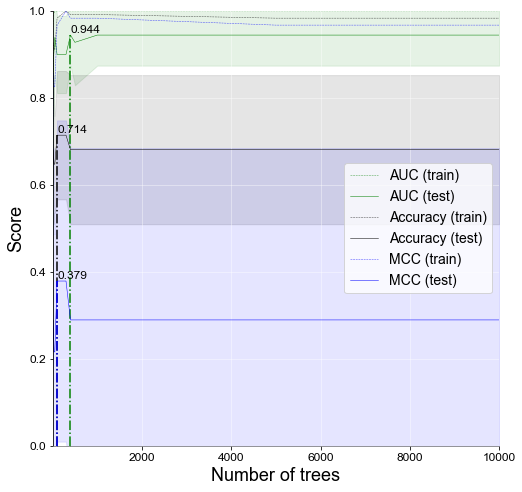

In [7]:
plt.rcParams["font.family"] = "arial"
fig = plt.figure(figsize=(8, 8))
plt.xlabel("Number of trees")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(5, 10000)
ax.set_ylim(0.0, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_n_estimators'].data, dtype=float)
for scorer, color in zip(sorted(scoring), ['g', 'k', 'b']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample),linewidth=0.5)

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]


    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=.5, ms=.5)

    # Annotate the best score for that scorer
    ax.annotate("%0.3f" % best_score,
                (X_axis[best_index], best_score + 0.005), size=12)

plt.legend(loc="best", fontsize=14)
plt.grid(False)
plt.xlabel("Number of trees", fontsize=18)
plt.ylabel("Score", fontsize=18)
ax.spines["bottom"].set_color('grey')
ax.grid(color="w", alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.savefig('opt_trees.pdf', bbox_inches='tight')
plt.show()

This is a lot to digest, so let's go through it step by step. 
First we will create a function to plot this, so we don't have to copy paste code all over the place, then we will zoom into the first part as it seems that after 1000 trees performance is stable.

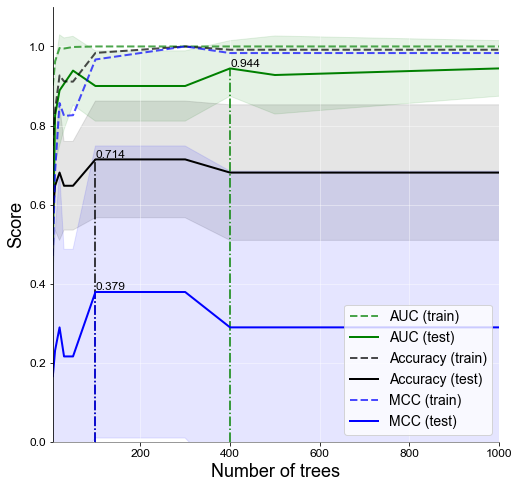

In [8]:
def plot_results_mcc(results, xlim, ylim):
    plt.rcParams["font.family"] = "arial"
    fig = plt.figure(figsize=(8, 8))
    plt.xlabel("Number of trees")
    plt.ylabel("Score")

    ax = plt.gca()
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results['param_n_estimators'].data, dtype=float)
    for scorer, color in zip(sorted(scoring), ['g', 'k', 'b']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample),linewidth=2)

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]


        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=.5, ms=.5)

        # Annotate the best score for that scorer
        ax.annotate("%0.3f" % best_score,
                    (X_axis[best_index], best_score + 0.005), size=12)

    plt.legend(loc="best", fontsize=14)
    plt.grid(False)
    plt.xlabel("Number of trees", fontsize=18)
    plt.ylabel("Score", fontsize=18)
    ax.spines["bottom"].set_color('grey')
    ax.grid(color="w", alpha=0.5)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    fig.savefig('opt_trees_zoom.pdf', bbox_inches='tight')
    plt.show()


# let's plot and zoom in the beginning of the search, so less than 1000 trees
plot_results_mcc(results, xlim=(5, 1000), ylim=(0.0, 1.1))


### Understanding overfitting and underfitting

**Ouch**! The first thing we can notice pretty easily is that the performance for the training data is extremely high no matter which metric we are looking at.
This suggest a certain degree of **overfitting**. 
*In this case the algorithm remembers the training data, rather than really learning the underlying features distribution*
This is particularly clear with low number of trees where we can see a *a poor performance on the test data but high performance on the training data*.
Every algorithm can and overfits to a certain extent and usually is very hard to avoid it. 
As this training and test dataset have very small number of samples, _it is possible that the algorithm remembers some examples and gets trapped into some local optimal solution instead of reaching the global minimum
Luckilly for us, it is still learning!

On the side note, we can see that while AUC is reasonably high for the test data, the MCC is very low (i.e < 0.4).

For highly unbalanced data, looking at accuracy is praticaly useless because classifying all samples in one or the other class will lead to high accuracy but actually bad performance.

Let's say we have 10 positive and 1 negative. If we classify all as positive we get high accuracy, but are we really learning? Hardly!

In our particular case, we have very few samples so it is very tricky to make final decisions on which metric to report, and it is probably a good idea to always monitor several in one go. 

In the [paper](https://www.cell.com/cell/fulltext/S0092-8674(20)30627-9#supplementaryMaterial), the authors reported AUC as metric usually improved. Lately a lot of publications in the machine learning field in parallel report also precision-recall curve as this gives a better/complementary overview on performance.
For some in depth explanation of why reporting only AUC might not be a great idea [here](http://sandeeptata.blogspot.com/2015/04/on-dangers-of-auc.html) there is a great resource.



Next time, we will dive deep into data preprocessing to figure out how we can 

- Preprocess the training data to try mitigate overfitting
- Create robust pipelines for data preprocessing using Sklearn

See you next time!